# Analyzing CRC models

In [45]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import color_pal as pal
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_sampling_api
import seaborn as sns
from pymc3_models import crc_models
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [25]:
data_dir = Path("..", "modeling_data", "depmap_CRC_data_subsample.csv")
data = dphelp.read_achilles_data(data_dir, low_memory=False)
data.shape

(34760, 30)

## Model 1

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


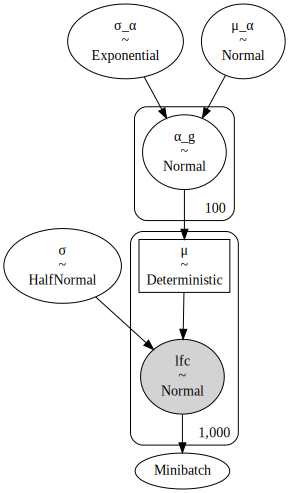

In [26]:
m1_cache_dir = pymc3_cache_dir / "CRCtestmodel1"

gene_idx = dphelp.get_indices(data, "hugo_symbol")

crc_model1 = crc_models.model_1(
    gene_idx=gene_idx, lfc_data=data.lfc.values, batch_size=1000
)
pm.model_to_graphviz(crc_model1)

In [27]:
crc_model1_res = pymc3_sampling_api.read_cached_vi(m1_cache_dir)

Loading cached trace and posterior sample...


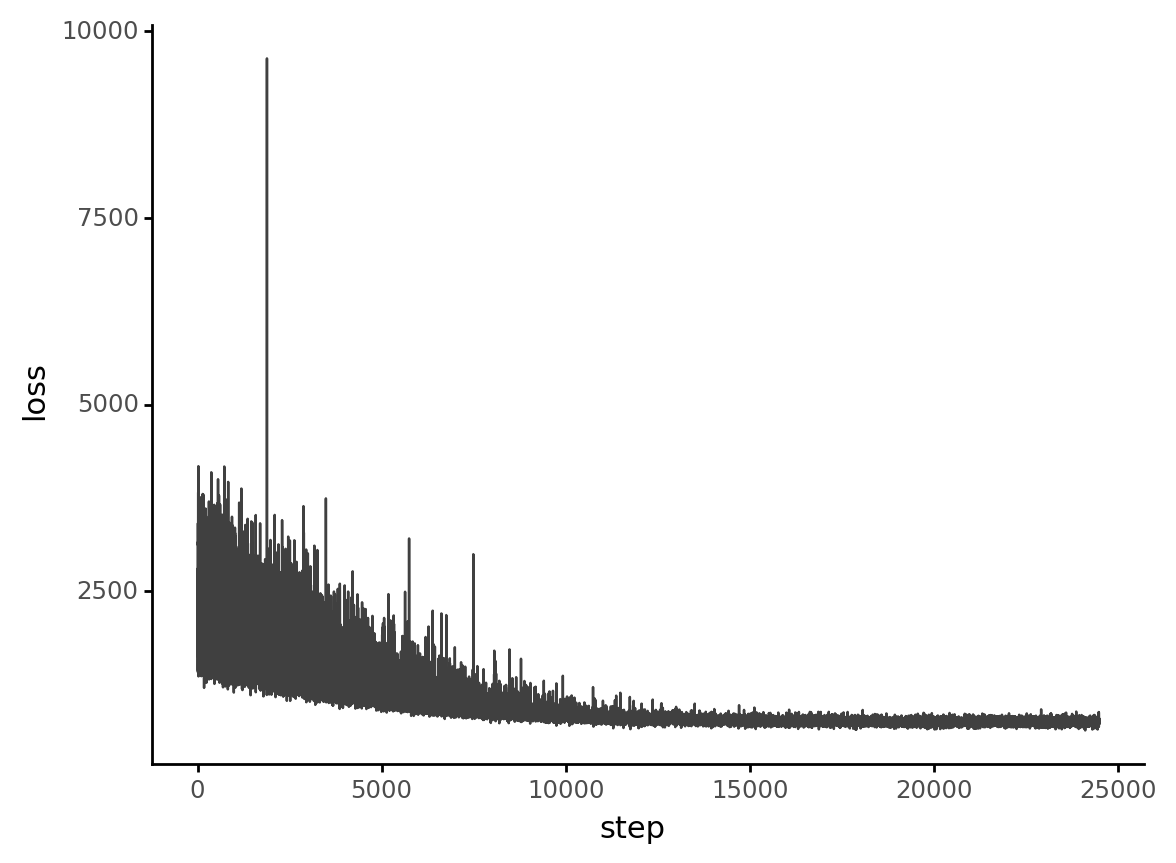

<ggplot: (8781401427083)>

In [28]:
d = pd.DataFrame({"loss": crc_model1_res["approximation"].hist}).assign(
    step=lambda d: np.arange(d.shape[0])
)

(
    gg.ggplot(d, gg.aes(x="step", y="loss"))
    + gg.geom_line(size=0.5, alpha=0.75, color="black")
)

In [29]:
crc_m1_az = az.from_pymc3(trace=crc_model1_res["trace"], model=crc_model1)
az.summary(crc_m1_az, var_names=["μ_α", "σ_α", "σ"], hdi_prob=0.89)

Exception ignored in: <function Minibatch.__del__ at 0x7fc94e214310>
Traceback (most recent call last):
  File "/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py", line 339, in __del__
    del Minibatch.RNG[id(self)]
KeyError: 140502425574656
Exception ignored in: <function Minibatch.__del__ at 0x7fc94e214310>
Traceback (most recent call last):
  File "/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py", line 339, in __del__
    del Minibatch.RNG[id(self)]
KeyError: 140502426185344
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.129,0.038,-0.187,-0.067,0.001,0.001,1088.0,1049.0,1100.0,921.0,NaN
σ_α,0.319,0.025,0.277,0.356,0.001,0.001,869.0,866.0,871.0,918.0,NaN
σ,0.509,0.008,0.496,0.522,0.000,0.000,941.0,941.0,942.0,947.0,NaN


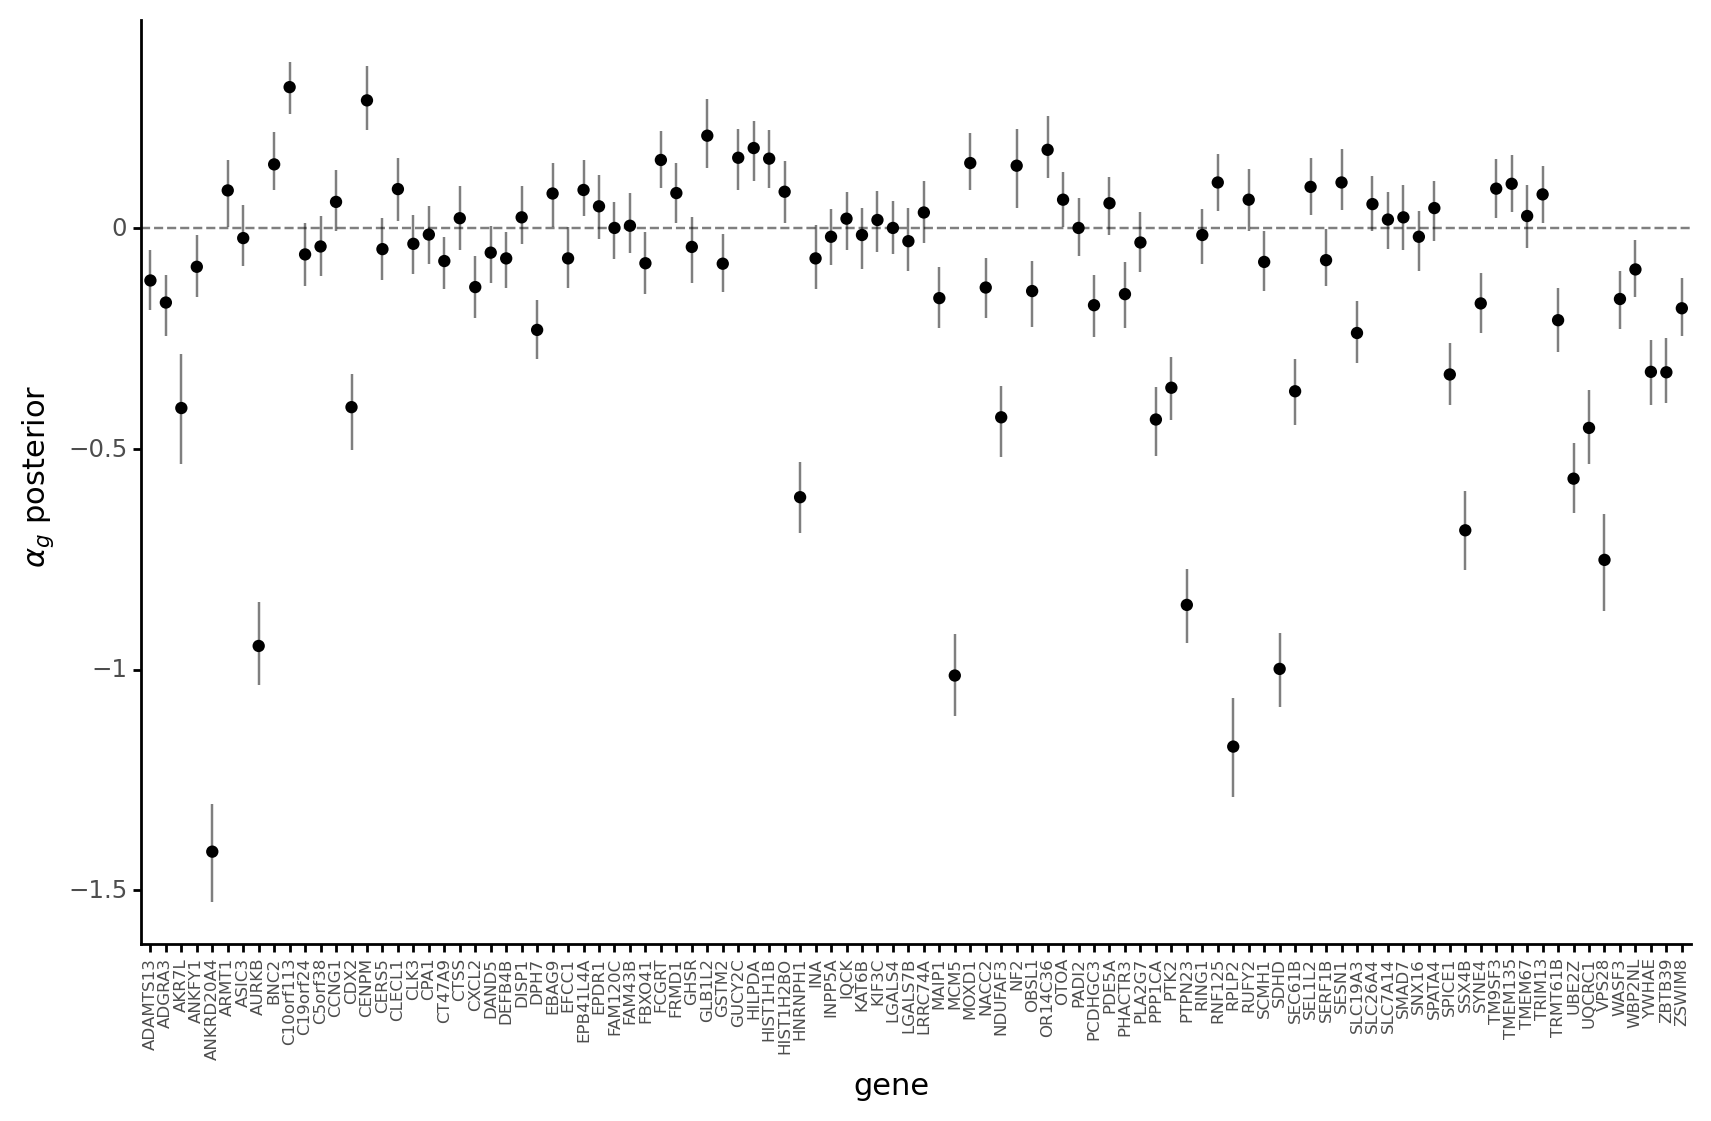

<ggplot: (8781400371297)>

In [39]:
gene_post = az.summary(crc_m1_az, var_names=["α_g"], hdi_prob=0.89, kind="stats")
gene_post["hugo_symbol"] = data.hugo_symbol.cat.categories.values
gene_post = gene_post.merge(
    data.groupby("hugo_symbol")["lfc"].agg(np.mean).reset_index(drop=False),
    on="hugo_symbol",
)

(
    gg.ggplot(gene_post, gg.aes(x="hugo_symbol"))
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), alpha=0.5)
    + gg.geom_point(gg.aes(y="mean"))
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=6), figure_size=(10, 6))
    + gg.labs(x="gene", y=r"$\alpha_g$ posterior")
)

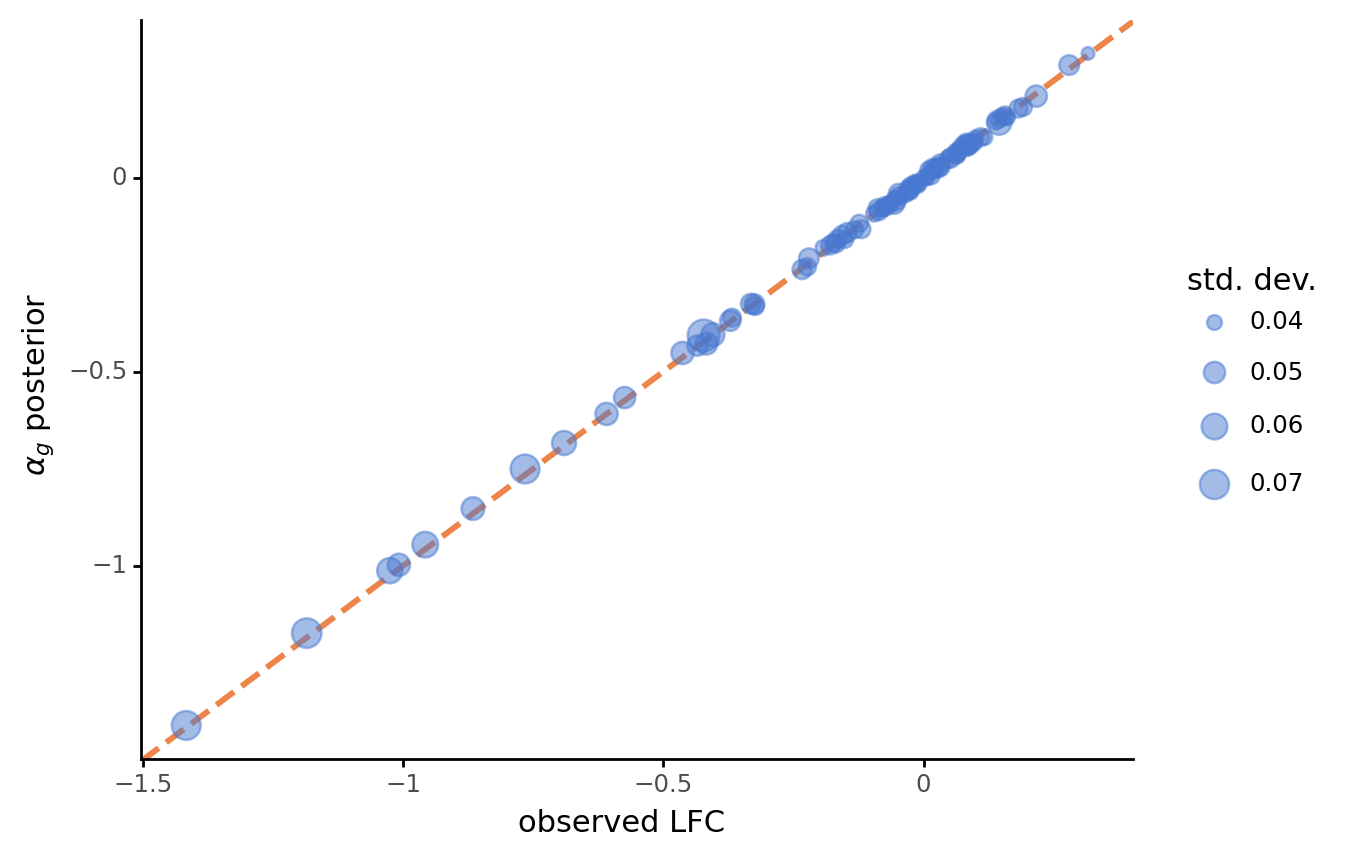

<ggplot: (8781392909433)>

In [50]:
(
    gg.ggplot(gene_post, gg.aes(x="lfc", y="mean"))
    + gg.geom_abline(
        slope=1, intercept=0, linetype="--", color=pal.sns_orange, size=1.2
    )
    + gg.geom_point(gg.aes(size="sd"), alpha=0.5, color=pal.sns_blue)
    + gg.labs(x="observed LFC", y=r"$\alpha_g$ posterior", size="std. dev.")
)

The posterior predictive check has the wrong dimensions; it is using the last minibatch for predicitions.
I need to follow the guidance of this [post](https://discourse.pymc.io/t/minibatch-advi-ppc-dimensions/5583) on the Discourse which followed the explanation in this GitHub [issue](https://github.com/pymc-devs/pymc3/issues/2190#issuecomment-311609342).
Should be a simple fix.

In [58]:
crc_model1_res["posterior_predictive"]["lfc"].shape

(1000, 1000)

In [54]:
data.shape

(34760, 30)

### To-Do:

1. Address the change above to fix an issue with PPC sampling.
2. Make sure I can replace the shared data with new data for predictions on unseen data.
3. Run and analyze more simple models.
4. Create a Snakemake workflow to run all in parallel and then run the analysis.

---

In [31]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.22 minutes


In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-02-18

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-17-96.o2.rc.hms.harvard.edu

Git branch: crc

re        : 2.2.1
plotnine  : 0.7.1
pandas    : 1.2.2
theano    : 1.0.5
seaborn   : 0.11.1
pymc3     : 3.11.1
matplotlib: 3.3.4
numpy     : 1.20.1
arviz     : 0.11.1

